# <center>Improving going-concern assumption through machine learning</center>

In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, silhouette_score
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import norm, spearmanr
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

### Working sample

Sample consists of 100 entities operating in the construction sector in Bulgaria. 50% of them are declared bankrupt in 2021. 50% of them are with good financial performance. All the necessary data are derived from the Bulgarian Commercial Register.

In [2]:
gc_data = pd.read_excel("data/sample.xlsx")

In [3]:
gc_data.head()

,COMPANY,ID_COM_REG,TLTA,RETA,QACL,NITA,CLASS
0,VODOPROVODI I KANALI EOOD,202638174,3.131944,-1.378472,0.018847,0.21700,NGC
1,JuLISIS 09 EOOD,200543293,0.857576,0.124242,0.085714,0.00318,NGC
2,AVE-STROJ EOOD,105544996,0.752412,0.199357,0.248366,0.03499,NGC
3,ALERLO EOOD,204845976,0.000000,0.000000,0.000000,0.00000,NGC
4,OKSET EOOD,200760731,0.000000,0.000000,0.000000,-1.00000,NGC


### Feature selection and preprocessing

Being features with high entropy, COMPANY and ID_COM_REG are ignored for the analysis.

In [4]:
features = gc_data[["TLTA", "RETA", "QACL","NITA"]]
target = gc_data["CLASS"]

Features are fit to normal distribution by applying log transformation. NaN and inf/-inf values are replaced with 0.

In [5]:
def fit_normal_distr(features, target):
    
    # Applying log transformation to fit to normal distribution
    norm_features = np.log1p(features)
    
    # Reaplacing values where log has returnd "inf" or "nan" with 0
    norm_features.replace([np.inf, -np.inf], 0, inplace=True)
    norm_features.fillna(value=0, axis=1, inplace=True)
      
    # Performs normalization
    normalizer = MinMaxScaler(copy=False)
    normalizer.fit_transform(norm_features)
    
    # One-Hot-Encoding target variable
    encoder = LabelBinarizer()
    target = encoder.fit_transform(target)
    
    
    return norm_features, target

In [6]:
norm_features, target = fit_normal_distr(features, target)

Plotting features before and after preprocessing.

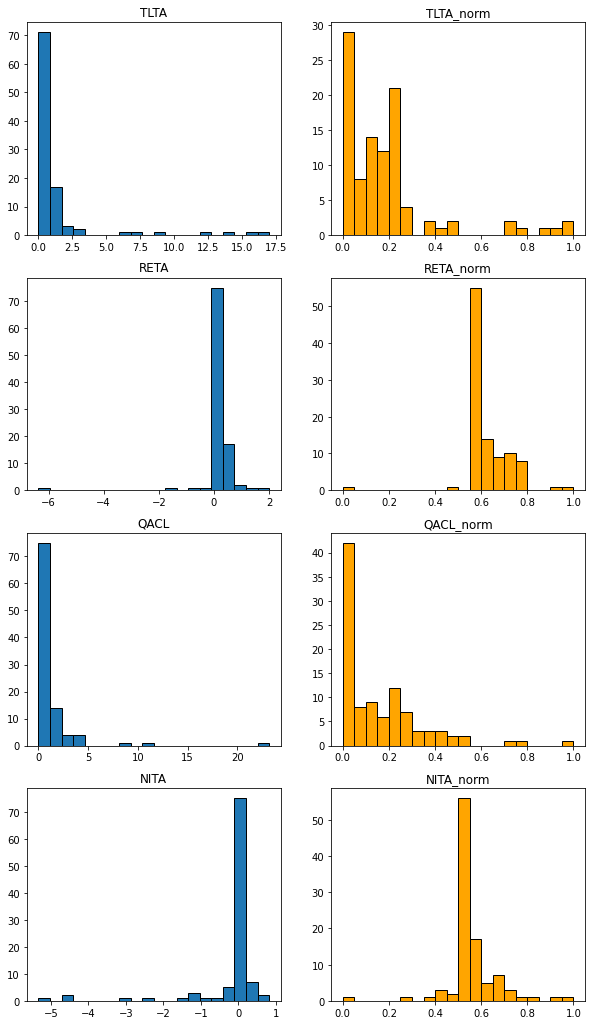

In [7]:
# Plots features before and after preprocessing

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,18))
fig.canvas.set_window_title('Window Title')

axs[0, 0].hist(features["TLTA"], edgecolor='black', bins=20)
axs[0, 0].set_title("TLTA")
axs[0, 1].hist(norm_features["TLTA"], edgecolor='black', bins=20, color="orange")
axs[0, 1].set_title("TLTA_norm")

axs[1, 0].hist(features["RETA"], edgecolor='black', bins=20)
axs[1, 0].set_title("RETA")
axs[1, 1].hist(norm_features["RETA"], edgecolor='black', bins=20, color="orange")
axs[1, 1].set_title("RETA_norm")

axs[2, 0].hist(features["QACL"], edgecolor='black', bins=20)
axs[2, 0].set_title("QACL")
axs[2, 1].hist(norm_features["QACL"], edgecolor='black', bins=20, color="orange")
axs[2, 1].set_title("QACL_norm")

axs[3, 0].hist(features["NITA"], edgecolor='black', bins=20)
axs[3, 0].set_title("NITA")
axs[3, 1].hist(norm_features["NITA"], edgecolor='black', bins=20, color="orange")
axs[3, 1].set_title("NITA_norm")

plt.savefig("norm")
plt.show()

In [8]:
# Creating a new dataframe in order to calculate correlation between features and target variable.
corr_df = norm_features[["TLTA", "RETA", "QACL","NITA"]].copy()
corr_df["CLASS"] = target.copy()

In [9]:
corr_df

,TLTA,RETA,QACL,NITA,CLASS
0,0.490853,0.574217,0.005859,0.689508,1
1,0.214254,0.619604,0.025806,0.539741,1
2,0.194090,0.644671,0.069612,0.563938,1
3,0.000000,0.574217,0.000000,0.537280,1
4,0.000000,0.574217,0.000000,0.537280,1
...,...,...,...,...,...
95,0.083436,0.000000,0.265883,0.928138,0
96,0.384048,0.574217,0.062487,0.537280,0
97,0.152877,0.574217,0.140559,0.708955,0
98,0.113143,0.717217,0.103398,0.532142,0


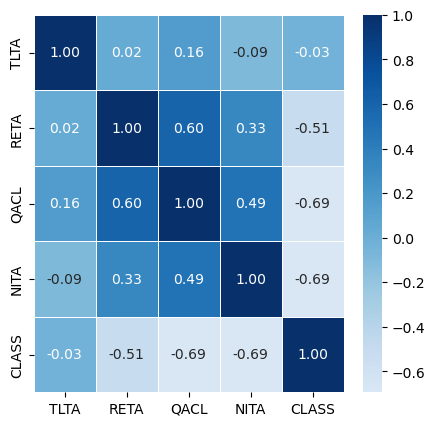

In [77]:
plt.figure(figsize=(5,5), dpi=100)
sns.heatmap(corr_df.corr(method="spearman"), annot=True, linewidth=0.5, fmt=".2f", cmap="Blues", center = 0)
#plt.savefig("corrmatrix")
plt.show()

In [11]:
# PLOTS ALONG WITH NORM DISTR


# plt.hist(norm_features["QACL"])

# mu, std = norm.fit(norm_features["QACL"])

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)

# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
# plt.title(title)

In [12]:
#In addition to cross-validation, a hold-out test set is set aside.

In [13]:
# Set aside a 20% hold-out set

#strat_shuf_split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

In [14]:
#for train_index, test_index in strat_shuf_split.split(norm_features, target):
    #features_train, features_test = norm_features.iloc[train_index], norm_features.iloc[test_index]
    #target_train, target_test = target.iloc[train_index], target.iloc[test_index]

### KNN Model

The first algorithm to be implemented is k-Nearest Neighbor (kNN). It would be hypertuned (number of neighbors from 1 to 24) through GridSearchCV. 

In [15]:
# Setting a parameter grid which contains different values of number of neighbors (from 1 to 24)

parameter_grid = {"n_neighbors": np.arange(1, 25)}

In [16]:
parameter_grid

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])}

In [17]:
classifier = KNeighborsClassifier()

In [18]:
# Applying 10-fold cross-validation

knn_gscv = GridSearchCV(classifier, param_grid=parameter_grid, cv=5, return_train_score=True)

In [19]:
knn_gscv.fit(norm_features, target)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             return_train_score=True)

In [20]:
knn_gscv.best_params_

{'n_neighbors': 6}

In [21]:
knn_gscv.best_score_

0.8799999999999999

In [22]:
knn_gscv.cv_results_["params"]

[{'n_neighbors': 1},
 {'n_neighbors': 2},
 {'n_neighbors': 3},
 {'n_neighbors': 4},
 {'n_neighbors': 5},
 {'n_neighbors': 6},
 {'n_neighbors': 7},
 {'n_neighbors': 8},
 {'n_neighbors': 9},
 {'n_neighbors': 10},
 {'n_neighbors': 11},
 {'n_neighbors': 12},
 {'n_neighbors': 13},
 {'n_neighbors': 14},
 {'n_neighbors': 15},
 {'n_neighbors': 16},
 {'n_neighbors': 17},
 {'n_neighbors': 18},
 {'n_neighbors': 19},
 {'n_neighbors': 20},
 {'n_neighbors': 21},
 {'n_neighbors': 22},
 {'n_neighbors': 23},
 {'n_neighbors': 24}]

In [23]:
# Function which plots test vs train accuracy

def plot_train_test_score(test_score, train_score, x, best_parameter, xlabel, ylabel, xticks):
    plt.figure(figsize=(8,5), dpi=100)
    plt.plot(x, test_score, label="test_score")
    plt.plot(x, train_score, label="train_score")
    plt.axvline(x=best_parameter, color="r", ls="--", label="best_score")
    plt.xlabel(xlabel)
    plt.xticks(xticks)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

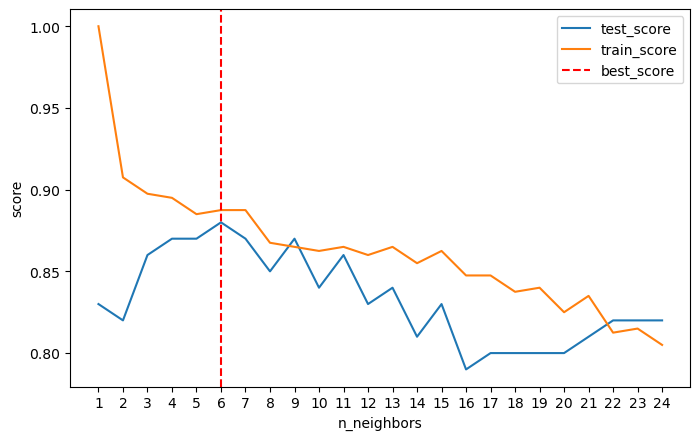

In [24]:
plot_train_test_score(test_score=knn_gscv.cv_results_["mean_test_score"], 
                      train_score=knn_gscv.cv_results_["mean_train_score"],
                      x=parameter_grid["n_neighbors"],
                      best_parameter=knn_gscv.best_params_["n_neighbors"],
                      xlabel="n_neighbors",
                      ylabel="score",
                      xticks=parameter_grid["n_neighbors"])

The number of neighbors which yields highest classification (0.88) is 6.

### Linear Regression

In [25]:
alphas_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

In [26]:
ridgereg = RidgeClassifier()

In [27]:
ridgereg_gscv = GridSearchCV(ridgereg, alphas_grid, cv=5, return_train_score=True)

In [28]:
ridgereg_gscv.fit(norm_features, target)

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True)

In [29]:
ridgereg_gscv.best_score_

0.85

In [30]:
ridgereg_gscv.best_params_

{'alpha': 0.001}

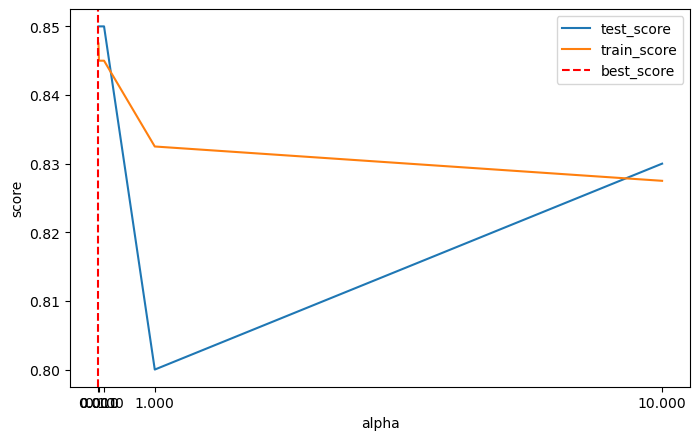

In [31]:
plot_train_test_score(test_score=ridgereg_gscv.cv_results_["mean_test_score"], 
                      train_score=ridgereg_gscv.cv_results_["mean_train_score"],
                      x=alphas_grid["alpha"],
                      best_parameter=ridgereg_gscv.best_params_["alpha"],
                      xlabel="alpha",
                      ylabel="score",
                      xticks=alphas_grid["alpha"])

### Decision Tree

In [32]:
params =  {
    'min_samples_leaf': [1, 2, 3, 4],
    'max_depth': [1, 2, 3, 4],
    'max_features': [1, 2, 3, 4]}

In [33]:
dt= DecisionTreeClassifier()

In [34]:
dt_gscv = GridSearchCV(dt, params, cv=5, return_train_score=True)

In [35]:
dt_gscv.fit(norm_features, target)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 3, 4]},
             return_train_score=True)

In [36]:
dt_gscv.best_estimator_

DecisionTreeClassifier(max_depth=2, max_features=3, min_samples_leaf=3)

In [37]:
dt_gscv.best_score_

0.9099999999999999

In [38]:
best_dt = dt_gscv.best_estimator_

In [39]:
best_dt.fit(norm_features, target)

DecisionTreeClassifier(max_depth=2, max_features=3, min_samples_leaf=3)

In [40]:
text_representation = tree.export_text(best_dt)
print(text_representation)

|--- feature_3 <= 0.54
|   |--- feature_1 <= 0.60
|   |   |--- class: 1
|   |--- feature_1 >  0.60
|   |   |--- class: 1
|--- feature_3 >  0.54
|   |--- feature_2 <= 0.08
|   |   |--- class: 0
|   |--- feature_2 >  0.08
|   |   |--- class: 0



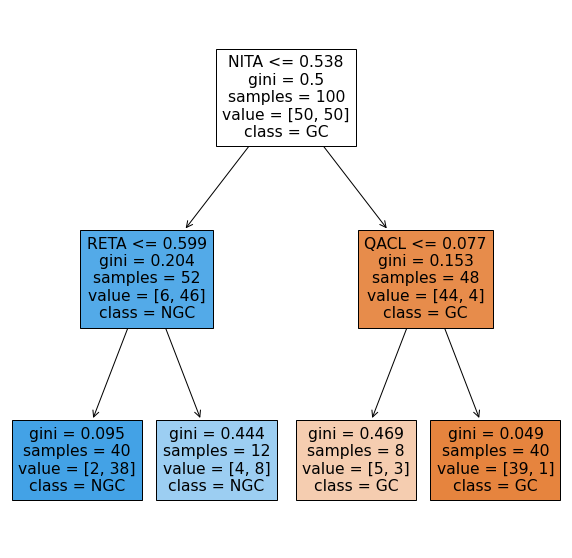

In [41]:
plt.figure(figsize=(10,10))
tree.plot_tree(best_dt,feature_names=norm_features.columns.tolist(), class_names=["GC", "NGC"], filled=True)
#plt.savefig("tree")
plt.show()

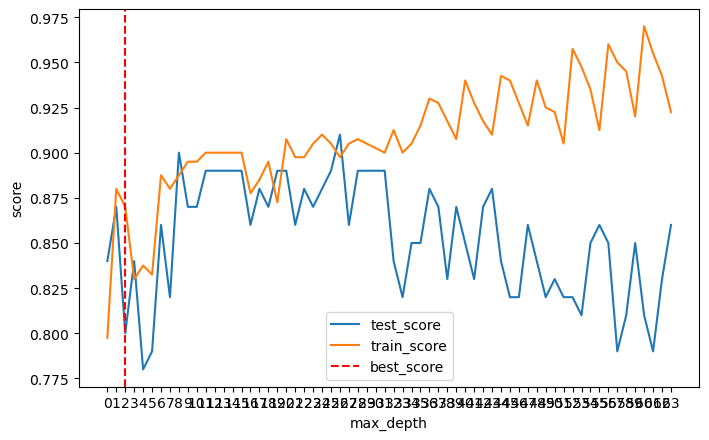

In [42]:
# MOSTLY WRONG

plot_train_test_score(test_score=dt_gscv.cv_results_["mean_test_score"], 
                      train_score=dt_gscv.cv_results_["mean_train_score"],
                      x= np.arange(0, len(dt_gscv.cv_results_["params"])),
                      best_parameter=dt_gscv.best_params_["max_depth"],
                      xlabel="max_depth",
                      ylabel="score",
                      xticks=np.arange(0, len(dt_gscv.cv_results_["params"])))

In [43]:
svc_grid = {"C": [0.001, 0.01, 0.1, 1],
           "kernel": ["linear", "poly", "rbf", "sigmoid"],
           "degree": [1, 2, 3, 4],
           "gamma": ["scale", "auto"],
           "class_weight": ["balanced", "none"]}

In [44]:
svc = SVC(random_state=42)

In [45]:
svc_gscv = GridSearchCV(svc, svc_grid, return_train_score=True)

In [46]:
svc_gscv.fit(features, target)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'class_weight': ['balanced', 'none'],
                         'degree': [1, 2, 3, 4], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True)

In [47]:
svc_gscv.cv_results_["mean_test_score"]

array([0.54, 0.55, 0.69, 0.59, 0.54, 0.55, 0.77, 0.62, 0.54, 0.53, 0.69,
       0.59, 0.54, 0.55, 0.77, 0.62, 0.54, 0.53, 0.69, 0.59, 0.54, 0.56,
       0.77, 0.62, 0.54, 0.54, 0.69, 0.59, 0.54, 0.57, 0.77, 0.62,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.66, 0.55,
       0.69, 0.59, 0.66, 0.61, 0.77, 0.62, 0.66, 0.55, 0.69, 0.59, 0.66,
       0.57, 0.77, 0.62, 0.66, 0.55, 0.69, 0.59, 0.66, 0.56, 0.77, 0.62,
       0.66, 0.55, 0.69, 0.59, 0.66, 0.56, 0.77, 0.62,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan, 0.76, 0.66, 0.69, 0.61,
       0.76, 0.68, 0.77, 0.61, 0.76, 0.57, 0.69, 0.61, 0.76, 0.67, 0.77,
       0.61, 0.76, 0.56, 0.69, 0.61, 0.76, 0.58, 0.

In [48]:
svc_gscv.best_params_["degree"]

1

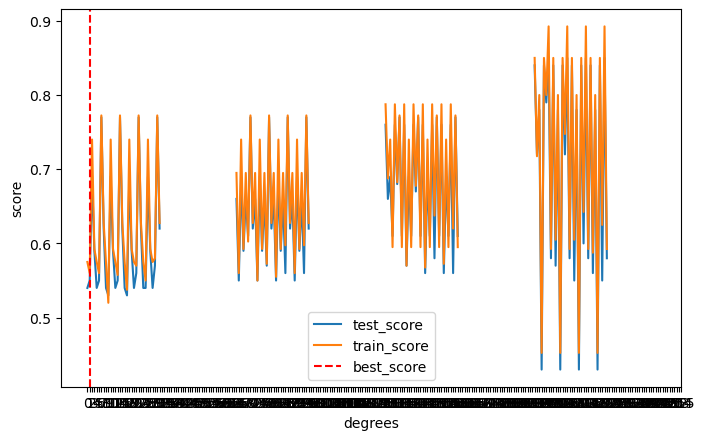

In [49]:
plot_train_test_score(test_score=svc_gscv.cv_results_["mean_test_score"],
                     train_score=svc_gscv.cv_results_["mean_train_score"],
                     x=np.arange(0, len(svc_gscv.cv_results_["mean_train_score"])),
                     best_parameter=svc_gscv.best_params_["degree"],
                     xlabel="degrees",
                     ylabel="score",
                     xticks=np.arange(0, len(svc_gscv.cv_results_["mean_train_score"])))